In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import astropy.units as u
import astropy.constants as c
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as cosmo
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
sys.path.insert(0, '/work/08811/aew492/ls6/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfunc_ls
import tools

In [3]:
def perh():
    return (cosmo.H(0.) / 100 * u.Mpc / u.km * u.s) / cu.littleh

In [4]:
def get_dx(z, sigma_z):
    return sigma_z * (1 + z) * c.c.to(u.km/u.s) / cosmo.H(z) * perh()

In [5]:
def eval_Gaussian(loc, sigma, mean=0.):
    # pre = 1 / (sigma * np.sqrt(2 * np.pi))
    pre = 1 / sigma.unit if hasattr(sigma, 'unit') else 1
    exp = -(loc-mean)**2 / (2 * sigma**2)
    return pre * np.e**exp

In [6]:
def wtheta_auto_LS(ra, dec, ra_rand, dec_rand, bins, nthreads=12):
    nd = len(ra)
    nr = len(ra_rand)
    binavg = 0.5 * (bins[1:] + bins[:-1])
    
    # DD
    DD_counts = DDtheta_mocks(1, nthreads, bins, ra, dec)
    # DR
    DR_counts = DDtheta_mocks(0, nthreads, bins, ra, dec, RA2=ra_rand, DEC2=dec_rand)
    # RR
    RR_counts = DDtheta_mocks(1, nthreads, bins, ra_rand, dec_rand)
    
    dd = np.array([x['npairs'] for x in DD_counts]) / (nd * (nd-1))
    dr = np.array([x['npairs'] for x in DR_counts]) / (nd * nd)
    rr = np.array([x['npairs'] for x in RR_counts]) / (nr * (nr-1))
    
    wtheta = np.empty(nbins)
    wtheta[:] = np.nan
    wtheta = np.divide(dd - 2 * dr + rr, rr, where=(rr!=0.), out=wtheta)
    
    return binavg, wtheta

In [7]:
def wtheta_auto_PH(ra, dec, ra_rand, dec_rand, bins, nthreads=12):
    nd = len(ra)
    nr = len(ra_rand)
    binavg = 0.5 * (bins[1:] + bins[:-1])
    
    # DD
    DD_counts = DDtheta_mocks(1, nthreads, bins, ra, dec)
    # RR
    RR_counts = DDtheta_mocks(1, nthreads, bins, ra_rand, dec_rand)
    
    dd = np.array([x['npairs'] for x in DD_counts]) / (nd * (nd-1))
    rr = np.array([x['npairs'] for x in RR_counts]) / (nr * (nr-1))
    
    wtheta = np.empty(nbins)
    wtheta[:] = np.nan
    wtheta = np.divide(dd, rr, where=(rr!=0.), out=wtheta) - 1
    
    return binavg, wtheta

In [8]:
def wtheta_cross_LS(ra1, dec1, ra2, dec2, ra_rand1, dec_rand1, ra_rand2, dec_rand2, bins, nthreads=12):
    nd1 = len(ra1)
    nd2 = len(ra2)
    nr1 = len(ra_rand1)
    nr2 = len(ra_rand2)
    binavg = 0.5 * (bins[1:] + bins[:-1])
    
    # D1D2
    D1D2_counts = DDtheta_mocks(0, nthreads, bins, ra1, dec1, RA2=ra2, DEC2=dec2)
    # D1R2
    D1R2_counts = DDtheta_mocks(0, nthreads, bins, ra1, dec1, RA2=ra_rand2, DEC2=dec_rand2)
    # D1R2
    D2R1_counts = DDtheta_mocks(0, nthreads, bins, ra2, dec2, RA2=ra_rand1, DEC2=dec_rand1)
    # R1R2
    R1R2_counts = DDtheta_mocks(0, nthreads, bins, ra_rand1, dec_rand1, RA2=ra_rand2, DEC2=dec_rand2)
    
    d1d2 = np.array([x['npairs'] for x in D1D2_counts]) / (nd1 * nd2)
    d1r2 = np.array([x['npairs'] for x in D1R2_counts]) / (nd1 * nr2)
    d2r1 = np.array([x['npairs'] for x in D2R1_counts]) / (nd2 * nr1)
    r1r2 = np.array([x['npairs'] for x in R1R2_counts]) / (nr1 * nr2)
    
    wtheta = np.empty(nbins)
    wtheta[:] = np.nan
    wtheta = np.divide(d1d2 - d1r2 - d2r1 + r1r2, r1r2, where=(r1r2!=0.), out=wtheta)
    
    return binavg, wtheta

In [9]:
def wtheta_cross_PH(ra1, dec1, ra2, dec2, ra_rand2, dec_rand2, bins, nthreads=12):
    nd1 = len(ra1)
    nd2 = len(ra2)
    nr2 = len(ra_rand2)
    binavg = 0.5 * (bins[1:] + bins[:-1])
    
    # D1D2
    D1D2_counts = DDtheta_mocks(0, nthreads, bins, ra1, dec1, RA2=ra2, DEC2=dec2)
    # D1R2
    D1R2_counts = DDtheta_mocks(0, nthreads, bins, ra1, dec1, RA2=ra_rand2, DEC2=dec_rand2)
    
    d1d2 = np.array([x['npairs'] for x in D1D2_counts]) / (nd1 * nd2)
    d1r2 = np.array([x['npairs'] for x in D1R2_counts]) / (nd1 * nr2)
    
    wtheta = np.empty(nbins)
    wtheta[:] = np.nan
    wtheta = np.divide(d1d2, d1r2, where=(d1r2!=0.), out=wtheta) - 1
    
    return binavg, wtheta

### construct samples

In [10]:
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift)
sigma_z = 0.01  # one of the 5 redshift error bins in SPHEREx

**spectroscopic sample:** SPHEREx-like galaxies from TNG; spans 3D box

In [11]:
gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos_spec -= sim.boxsize / 2

 number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294


In [12]:
# divide into narrow 2D slices along the LOS
nslices = 11
L = sim.boxsize.value
losbins = np.linspace(-L/2, L/2, nslices+1)
slicewidth = (losbins[1]-losbins[0])
slice_centers = np.array([(losbins[i]+losbins[i+1])/2 for i in range(nslices)])

slices_spec = [
    gal_pos_spec[(losbins[i] <= gal_pos_spec[:,2].value) & (gal_pos_spec[:,2].value < losbins[i+1])] \
    for i in range(nslices)
]

Text(0.5, 0.98, 'Spectroscopic slices')

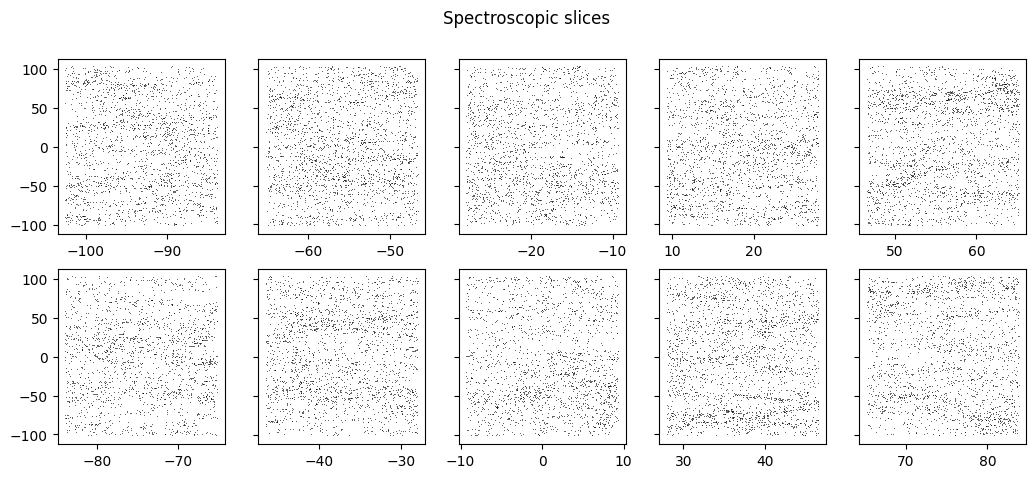

In [18]:
# check out the slices
nrows, ncols = 2, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2.5, nrows * 2.5))
kwargs = dict(ls='None', marker=',', ms=3, alpha=0.6)
for i in range(nslices-1):
    row = i % nrows
    col = (i - row) // nrows
    axs[row,col].plot(slices_spec[i][:,2].value, slices_spec[i][:,0].value, c='k', **kwargs)
    if col != 0:
        axs[row,col].set_yticklabels([])
fig.suptitle('Spectroscopic slices')

**photometric sample:** SPHEREx-like galaxies from TNG at the target redshift; selected from spectroscopic sample with a Gaussian centered at the box center

In [19]:
# dx = the standard deviation of the distance spread along the LOS
dx = get_dx(redshift, sigma_z)
dx

<Quantity 34.14988849 Mpc / littleh>

In [20]:
# select galaxies from the spectroscopic sample with a Gaussian PDF
gal_pos_phot = []
for i, pos in enumerate(gal_pos_spec):
    draw = eval_Gaussian(pos[2], dx) * dx.unit
    if draw > np.random.uniform():
        gal_pos_phot.append(pos)
    else:
        continue
gal_pos_phot = np.array(gal_pos_phot) * dx.unit

In [21]:
x, y, z = gal_pos_phot.T.value

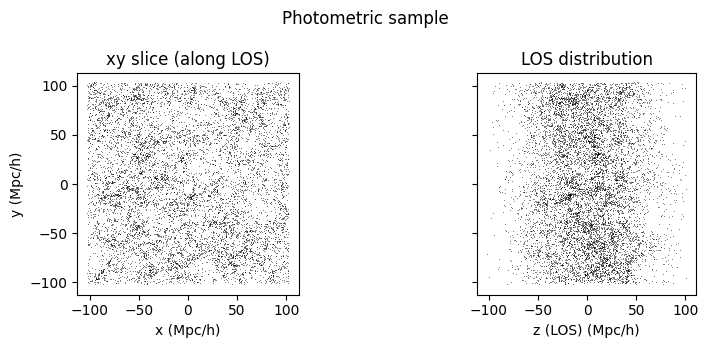

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(9,3.5))
kwargs = dict(c='k', marker=',', ls='None', alpha=0.5)
axs[0].plot(x, y, **kwargs)
axs[0].set_xlabel('x (Mpc/h)')
axs[0].set_ylabel('y (Mpc/h)')
axs[0].set_title('xy slice (along LOS)')
axs[1].plot(z, y, **kwargs)
axs[1].set_xlabel('z (LOS) (Mpc/h)')
axs[1].set_title('LOS distribution')
for i, ax in enumerate(axs):
    ax.set_aspect('equal')
    if i > 0:
        ax.set_yticklabels([])
fig.suptitle('Photometric sample')
fig.tight_layout()

### $w(\theta)$: angular autocorrelations

We need to convert Cartesian coordinates (x,y,z) into (RA,Dec,redshift); but let's start by taking all points to be at the same redshift.

In [23]:
def redshift_to_comov(z, cosmo=cosmo):
    r = cosmo.comoving_distance(z) * perh() # convert to Mpc/h
    return r

In [24]:
r = redshift_to_comov(redshift)
r

<Quantity 1317.92319893 Mpc / littleh>

In [25]:
# given the comoving distance to the box center, it should be just geometry to convert Cartesian (x,y,z) coords
#  in the box to (RA,Dec) on the sky from our observer pos
def CartesiantoEquatorial(pos, observer=[0,0,0]):
    x, y, z = (pos - np.array(observer)).T
    s = np.hypot(z, y) 
    lon = np.arctan2(y, z)
    lat = np.arctan2(x, s)

    # convert to degrees
    lon = np.rad2deg(lon)
    lat = np.rad2deg(lat)
    # wrap lon to [0,360]
    lon = np.mod(lon-360., 360.)
    return lon, lat

Set all positions along LOS to the box center, for now

In [26]:
gal_pos = np.copy(gal_pos_spec.value)
gal_pos[:,2] = 0
ra, dec = CartesiantoEquatorial(gal_pos, observer=[0.,0.,r.value])

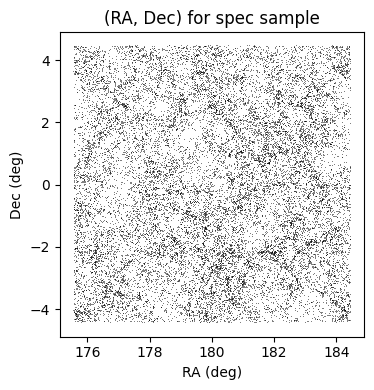

In [27]:
fig, ax = plt.subplots(figsize=(4,4))
kwargs = dict(c='k', marker=',', ls='None', alpha=0.5)
ax.plot(ra, dec, **kwargs)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_aspect('equal')
ax.set_title('(RA, Dec) for spec sample')
fig.tight_layout()

#### angular correlation function

In [28]:
# random catalog
n = len(gal_pos_spec)
ra_rand = np.random.uniform(min(ra), max(ra), n)
dec_rand = np.random.uniform(min(dec), max(dec), n)

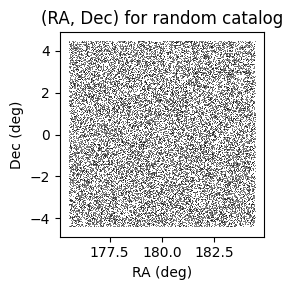

In [29]:
fig, ax = plt.subplots(figsize=(3,3))
kwargs = dict(c='k', marker=',', ls='None', alpha=0.5)
ax.plot(ra_rand, dec_rand, **kwargs)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_aspect('equal')
ax.set_title('(RA, Dec) for random catalog')
fig.tight_layout()

In [30]:
# separation bins
nbins = 10
bins = np.logspace(np.log10(0.001), np.log10(5.), nbins+1)

In [31]:
thetaavg, wtheta_LS = wtheta_auto_LS(ra, dec, ra_rand, dec_rand, bins)

In [32]:
thetaavg, wtheta_PH = wtheta_auto_PH(ra, dec, ra_rand, dec_rand, bins)

Text(0.5, 1.0, '$w(\\theta)$ autocorr, spectroscopic sample')

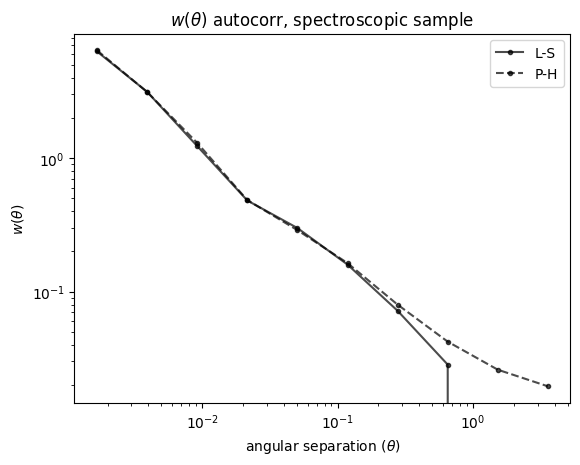

In [33]:
fig, ax = plt.subplots()
ax.plot(thetaavg, wtheta_LS, 'k.-', alpha=0.7, label='L-S')
ax.plot(thetaavg, wtheta_PH, 'k.--', alpha=0.7, label='P-H')
ax.set_xlabel(r'angular separation ($\theta$)')
ax.set_ylabel(r'$w(\theta)$')
ax.loglog()
ax.legend()
ax.set_title(r'$w(\theta)$ autocorr, spectroscopic sample')

### $w(\theta)$: angular cross-correlations

Cross-correlate the photometric sample with each spectroscopic slice.

In [34]:
nslices, slices_spec[0].shape, gal_pos_phot.shape

(11, (2155, 3), (9805, 3))

In [35]:
# convert photometric sample to (RA,Dec), setting LOS positions to box center
gal_pos = np.copy(gal_pos_phot.value)
gal_pos[:,2] = 0
ra_phot, dec_phot = CartesiantoEquatorial(gal_pos, observer=[0.,0.,r.value])

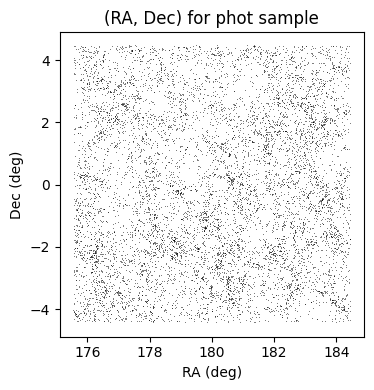

In [36]:
fig, ax = plt.subplots(figsize=(4,4))
kwargs = dict(c='k', marker=',', ls='None', alpha=0.5)
ax.plot(ra_phot, dec_phot, **kwargs)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_aspect('equal')
ax.set_title('(RA, Dec) for phot sample')
fig.tight_layout()

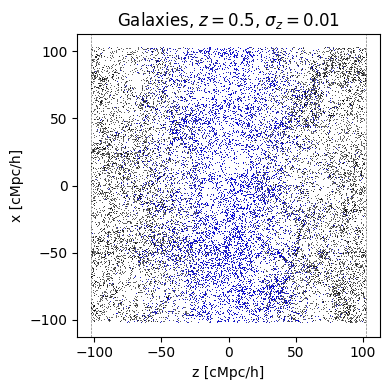

In [37]:
# compare positions
fig, ax = plt.subplots(figsize=(7,4))

kwargs = dict(ls='None', marker=',', alpha=0.6)
ax.plot(gal_pos_spec[:,2].value, gal_pos_spec[:,0].value, c='k', **kwargs)
ax.plot(gal_pos_phot[:,2].value, gal_pos_phot[:,0].value, c='b', **kwargs)
ax.axvline(-(sim.boxsize.value)/2, ls='--', color='k', lw=0.5, alpha=0.5)
ax.axvline((sim.boxsize.value)/2, ls='--', color='k', lw=0.5, alpha=0.5)
ax.set_aspect('equal')
ax.set_xlabel('z [cMpc/h]')
ax.set_ylabel('x [cMpc/h]')
ax.set_title(f'Galaxies, $z={redshift}$, $\sigma_z={sigma_z}$')
fig.tight_layout()

In [38]:
# random catalog for photometric sample
nd1 = len(gal_pos_phot)
ra_rand_phot = np.random.uniform(min(ra_phot), max(ra_phot), nd1)
dec_rand_phot = np.random.uniform(min(dec_phot), max(dec_phot), nd1)

In [39]:
xcorrs = np.empty((nslices, nbins))
for i, spec_slice in enumerate(slices_spec):
    # prep spectroscopic slice and corresponding random set
    nd2 = len(spec_slice)
    gal_pos_ = np.copy(spec_slice.value)
    gal_pos_[:,2] = 0
    ra_spec_, dec_spec_ = CartesiantoEquatorial(gal_pos_, observer=[0.,0.,r.value])
    ra_rand_spec_ = np.random.uniform(min(ra_spec_), max(ra_spec_), nd2)
    dec_rand_spec_ = np.random.uniform(min(dec_spec_), max(dec_spec_), nd2)
    
    # compute xcorr
    thetaavg, xcorrs[i] = wtheta_cross_LS(ra_phot, dec_phot, ra_spec_, dec_spec_,
                                          ra_rand_phot, dec_rand_phot, ra_rand_spec_, dec_rand_spec_, bins)

Text(0.5, 1.0, '$w(\\theta)$ cross-corr, phot. sample x spec. slices, LS estimator')

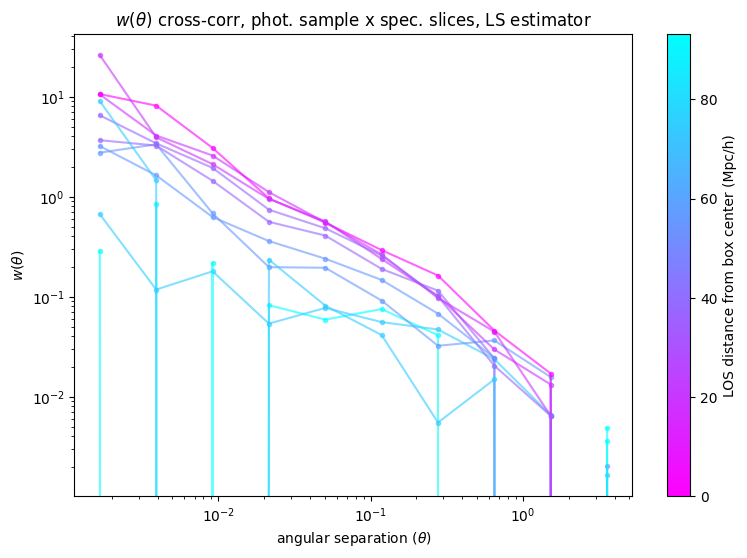

In [40]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(cmap='cool_r', norm=norm)

fig, ax = plt.subplots(figsize=(9,6))

for i, xcorr in enumerate(xcorrs):
    ax.plot(thetaavg, xcorr, marker='.', ls='-', alpha=0.6, c=smap.to_rgba(np.abs(slice_centers[i])))

ax.set_xlabel(r'angular separation ($\theta$)')
ax.set_ylabel(r'$w(\theta)$')
ax.loglog()

fig.colorbar(smap, ax=ax, label='LOS distance from box center (Mpc/h)')
ax.set_title(r'$w(\theta)$ cross-corr, phot. sample x spec. slices, LS estimator')

In [42]:
xcorrs_PH = np.empty((nslices, nbins))
for i, spec_slice in enumerate(slices_spec):
    # prep spectroscopic slice and corresponding random set
    nd2 = len(spec_slice)
    gal_pos_ = np.copy(spec_slice.value)
    gal_pos_[:,2] = 0
    ra_spec_, dec_spec_ = CartesiantoEquatorial(gal_pos_, observer=[0.,0.,r.value])
    ra_rand_spec_ = np.random.uniform(min(ra_spec_), max(ra_spec_), nd2)
    dec_rand_spec_ = np.random.uniform(min(dec_spec_), max(dec_spec_), nd2)
    
    # compute xcorr
    thetaavg, xcorrs_PH[i] = wtheta_cross_PH(ra_phot, dec_phot, ra_spec_, dec_spec_,
                                          ra_rand_phot, dec_rand_phot, bins)

Text(0.5, 1.0, '$w(\\theta)$ cross-corr, phot. sample x spec. slices, PH estimator')

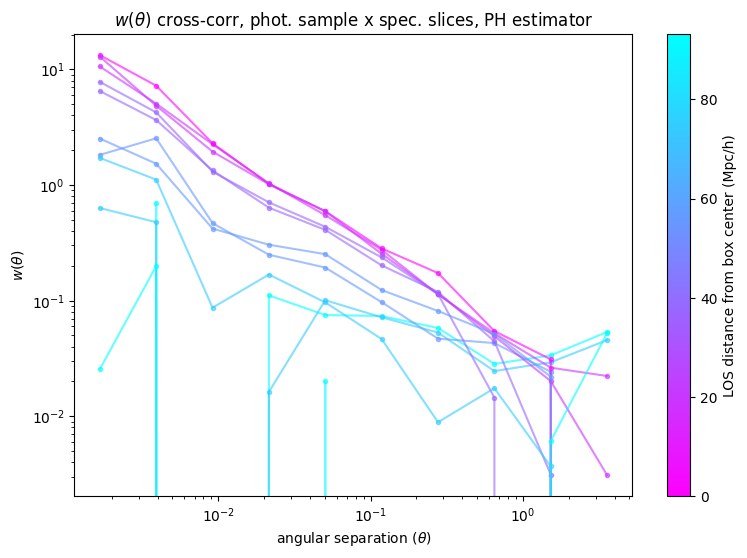

In [43]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(cmap='cool_r', norm=norm)

fig, ax = plt.subplots(figsize=(9,6))

for i, xcorr in enumerate(xcorrs_PH):
    ax.plot(thetaavg, xcorr, marker='.', ls='-', alpha=0.6, c=smap.to_rgba(np.abs(slice_centers[i])))

ax.set_xlabel(r'angular separation ($\theta$)')
ax.set_ylabel(r'$w(\theta)$')
ax.loglog()

fig.colorbar(smap, ax=ax, label='LOS distance from box center (Mpc/h)')
ax.set_title(r'$w(\theta)$ cross-corr, phot. sample x spec. slices, PH estimator')

### ratio of clustering amplitudes

In [44]:
slices_phot = [
    gal_pos_phot[(losbins[i] <= gal_pos_phot[:,2].value) & (gal_pos_phot[:,2].value < losbins[i+1])] \
    for i in range(nslices)
]
Ns = np.array([len(x) for x in slices_phot])

In [45]:
Ns

array([  46,  180,  626, 1170, 1818, 1930, 1817, 1388,  558,  203,   69])

In [46]:
ratios = Ns / max(Ns)

In [47]:
ratios

array([0.0238342 , 0.09326425, 0.32435233, 0.60621762, 0.94196891,
       1.        , 0.94145078, 0.71917098, 0.28911917, 0.10518135,
       0.0357513 ])

Text(0.5, 1.0, '$w_x(\\theta)$, phot. sample x spec. slices, PH estimator')

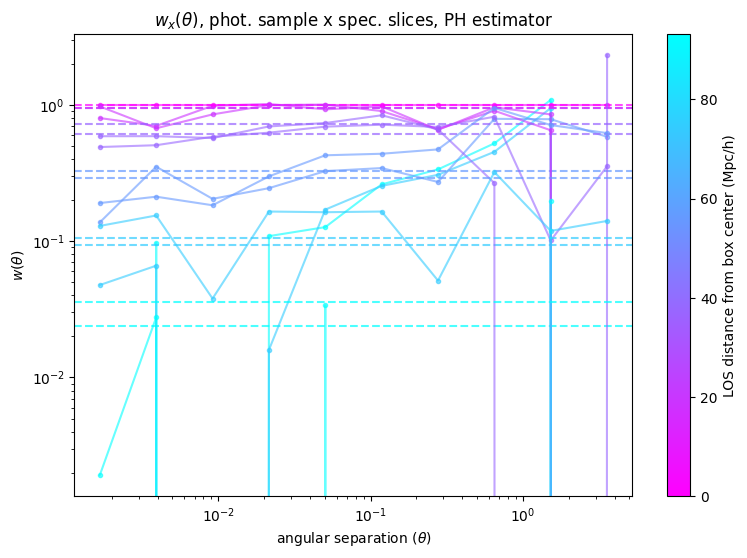

In [50]:
fig, ax = plt.subplots(figsize=(9,6))

# normalize each curve by the c.f. at the box center
xcorr_center = xcorrs_PH[len(xcorrs_PH)//2]

for i, xcorr in enumerate(xcorrs_PH):
    ax.plot(thetaavg, xcorr / xcorr_center, marker='.', ls='-', alpha=0.6, c=smap.to_rgba(np.abs(slice_centers[i])))
    ax.axhline(ratios[i], marker='None', ls='--', alpha=0.7, c=smap.to_rgba(np.abs(slice_centers[i])))

ax.set_xlabel(r'angular separation ($\theta$)')
ax.set_ylabel(r'$w(\theta)$')
ax.loglog()

fig.colorbar(smap, ax=ax, label='LOS distance from box center (Mpc/h)')
ax.set_title(r'$w_x(\theta)$, phot. sample x spec. slices, PH estimator')